<a href="https://colab.research.google.com/github/iceman011/mydeeplearning/blob/master/ez-mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torch import nn
import torch.nn.functional as F
import time

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt


class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5,lr =0.001):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input layer
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
        
        '''
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.learning_rate = lr
        # Input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)


def validation(model, validationloader, criterion):
    accuracy = 0
    test_loss = 0
    for images, labels in validationloader:

        images = images.resize_(images.size()[0], model.input_size)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ## Calculating the accuracy 
        # Model's output is log-softmax, take exponential to get the probabilities
        ps = torch.exp(output)
        # Class with highest probability is our predicted class, compare with true label
        #equality = (labels.data == ps.max(1)[1])
        # Accuracy is number of correct predictions divided by all predictions, just take the mean
        #accuracy += equality.type_as(torch.FloatTensor()).mean()


      
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))      
      
    test_loss = test_loss/len(validationloader)
    accuracy = accuracy/len(validationloader)

    return test_loss, accuracy


def train(model, trainloader, validationloader, criterion, optimizer, epochs=5, print_every=40):
    # monitor training loss    
    steps = 0
    start_time = time.time()
    train_losses, valid_losses = [], []
    
    print('Starting Training using Model Parameters ',model )

    for e in range(epochs):        
        train_loss = 0.0
        valid_loss = 0.0
        valid_loss_min = np.Inf # set initial "min" to infinity

        ###################
        # train the model #
        ###################
        model.train() # prep model for training

        for images, labels in trainloader:
            steps += 1
            
            # Flatten images into a 784 long vector
            images.resize_(images.size()[0], 784)
            
            optimizer.zero_grad()
            
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

        train_loss = train_loss/len(trainloader.sampler)
        train_losses.append(train_loss)
        ######################    
        # validate the model #
        ######################
        # Model in inference mode, dropout is off
        model.eval()
        
        # Turn off gradients for validation, will speed up inference
        with torch.no_grad():
            valid_loss, accuracy = validation(model, validationloader, criterion)
        
        valid_losses.append(valid_loss)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuracy : {:.6f}'.format(
            e+1, 
            train_loss,
            valid_loss,
            accuracy
            ))
        
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('\n Validation loss decreased ({:.6f} --> {:.6f} ,)  Accuracy: {:.6f}  TimeElapsed: {:.6f}.  Saving model ...'.format(
            valid_loss_min,
            valid_loss,
            accuracy,
            (time.time() - start_time)))
              
            checkpoint = {'Input Size': model.input_size,
                  'Output Size': model.output_size,
                  'HiddenLayers': [each.out_features for each in model.hidden_layers],
                  'LearningRate':model.learning_rate,
                  'Training Loss' :train_loss,
                  'Validation Loss ':valid_loss,
                  'Elapsed Time': (time.time() - start_time),
                  'CheckPoint Timestamp': time.time(),
                  'StateDictionay': model.state_dict()}
            
            #print(checkpoint)
            torch.save(checkpoint, 'minst_checkpoint_'+str(time.time())+'.pt')
            valid_loss_min = valid_loss
    return train_losses , valid_losses


def plotLossTrend(train_losses,validation_losses):
  plt.plot(train_losses, label='Training loss')
  plt.plot(validation_losses, label='Validation loss')
  plt.legend(frameon=False)


In [0]:
# import libraries
import torch
import numpy as np

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

Epoch: 1 	Training Loss: 0.021208 	Validation Loss: 0.152778 	Accuracy : 0.954502


 Validation loss decreased (inf --> 0.152778 ,)  Accuracy: 0.954502  TimeElapsed: 31.037267.  Saving model ...
Epoch: 2 	Training Loss: 0.011528 	Validation Loss: 0.122652 	Accuracy : 0.964252


 Validation loss decreased (inf --> 0.122652 ,)  Accuracy: 0.964252  TimeElapsed: 66.233518.  Saving model ...
Epoch: 3 	Training Loss: 0.009926 	Validation Loss: 0.111974 	Accuracy : 0.968836


 Validation loss decreased (inf --> 0.111974 ,)  Accuracy: 0.968836  TimeElapsed: 102.194459.  Saving model ...


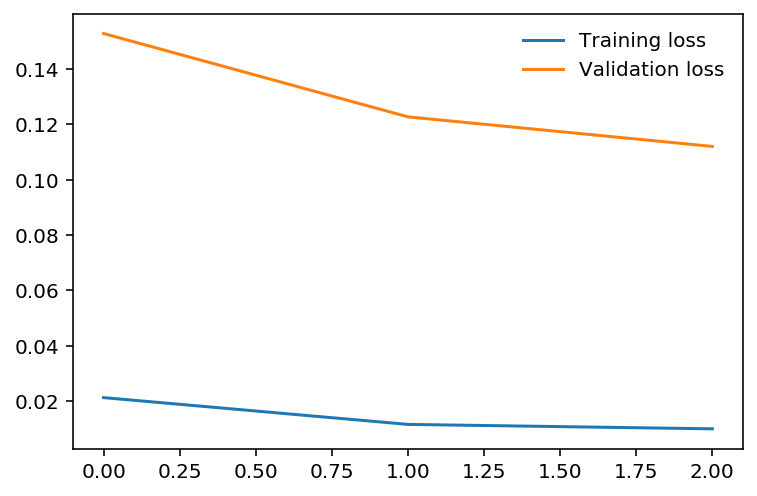

In [18]:
from torch import optim

# Create the network, define the criterion and optimizer

model = Network(784, 10, [512, 256, 128], lr=0.001)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses , valid_losses = train(model, train_loader, valid_loader, criterion, optimizer, epochs=3)

plotLossTrend (train_losses , valid_losses)